In [1]:
import os
BAR = 'Barcodes_1d'
ROOT = open('../root').read().strip()
print ROOT
img_path = os.path.join(ROOT, 'common')
print img_path
anno_path = os.path.join(ROOT, BAR, 'annotations.json')
print anno_path
voc_path = os.path.join(ROOT, 'VOC', 'JPEGImages')
print voc_path

/home/nik-kochetov/work
/home/nik-kochetov/work/common
/home/nik-kochetov/work/Barcodes_1d/annotations.json
/home/nik-kochetov/work/VOC/JPEGImages


In [2]:
import model
reload(model)
from model import SSDModel
ssd_model = SSDModel()

Using Theano backend.


dleft_block4_bbox (None, None, None, 1)
dtop_block4_bbox (None, None, None, 1)
dright_block4_bbox (None, None, None, 1)
dbottom_block4_bbox (None, None, None, 1)
block4_class (None, None, None, 1)


In [3]:
import json
with open(anno_path) as f:
    anno = json.loads(f.read())
print len(anno)
print anno[0]

8111
{u'name': u'0001.jpg', u'shape': [3585, 2661, 3], u'Rects': [[594, 1081, 326, 575], [568, 1054, 1131, 1382], [593, 1074, 718, 968], [572, 1057, 1566, 1817], [564, 1050, 1964, 2217], [567, 1048, 2437, 2691]], u'path': u'Barcodes_1d/UPC-E', u'id': u'0001', u'Types': [u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE']}


In [4]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [5]:
print ssd_model.cls_names
print ssd_model.bbox_names

['block4_class']
['dleft_block4_bbox', 'dtop_block4_bbox', 'dright_block4_bbox', 'dbottom_block4_bbox']


In [6]:
def tensor_dict_to_list(model, tensor_dict):
    lst = []
    for name in ssd_model.bbox_names:
        lst.append(tensor_dict[name])
    for name in ssd_model.cls_names:
        lst.append(tensor_dict[name])
    return lst

In [13]:
import generator
reload(generator)
from generator import Generator
ssd_generator = Generator(ROOT, ssd_model)

In [14]:
generator = ssd_generator.generate(anno[100:], 64, True)

In [15]:
print anno[100]

{u'name': u'0023.jpg', u'shape': [3490, 2479, 3], u'Rects': [[600, 902, 884, 1029], [1755, 2150, 724, 856]], u'path': u'Barcodes_1d/Reclamations Interleaved 2 of 5', u'id': u'0023', u'Types': [u'Interleaved25', u'Code39']}


In [16]:
print ssd_model.num_poolings

6


In [17]:
gen = next(generator)

next batch:
img: Barcodes_1d/Reclamations Interleaved 2 of 5/0023.jpg
window:  Rect(411, 574, 2459, 2622)
tensors: [(0, 0, 0.369140625, 0.60546875, 0.958984375, 0.888671875, 0.16704559326171875), (1, 0, 0.369140625, 0.10546875, 0.958984375, 0.388671875, 0.16704559326171875), (0, 1, 0.0, 0.60546875, 0.458984375, 0.888671875, 0.12998580932617188), (1, 1, 0.0, 0.10546875, 0.458984375, 0.388671875, 0.12998580932617188), (0, 5, 0.125, 0.29296875, 0.896484375, 0.55078125, 0.1988983154296875), (0, 6, 0.0, 0.29296875, 0.396484375, 0.55078125, 0.1022186279296875)]


In [18]:
for key, value in gen[1].items():
    print key, value.shape
print gen[0]['input'].shape

dtop_block4_bbox (1, 15, 15, 2)
dbottom_block4_bbox (1, 15, 15, 2)
block4_class (1, 15, 15, 1)
dleft_block4_bbox (1, 15, 15, 2)
dright_block4_bbox (1, 15, 15, 2)
(1, 512, 512, 3)


In [19]:
print anno[0]['path'] + '/' + anno[0]['name']

Barcodes_1d/UPC-E/0001.jpg


255.0 0.0


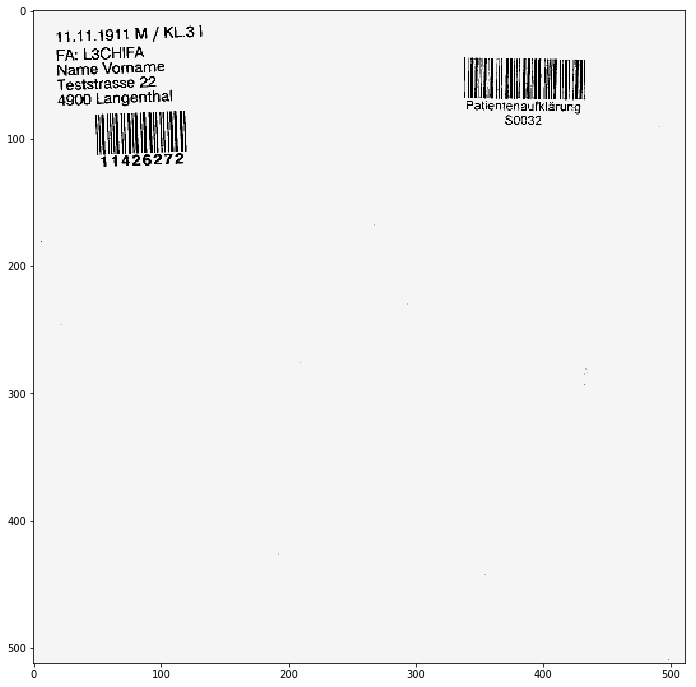

In [20]:
def show_img_from_gen(ax, gen):
    def unprocess(y):
            x = np.copy(y)
            # Zero-decenter by mean pixel
            x[:, :, :, 0] += 103.939
            x[:, :, :, 1] += 116.779
            x[:, :, :, 2] += 123.68

            # 'BGR'->'RGB'
            x = x[:, :, :, ::-1]
            print np.max(x), np.min(x)
            return x / 265.0


    ax.imshow(np.reshape(unprocess(gen[0]['input'])[0], gen[0]['input'].shape[1:]))
    
    
fig, ax = plt.subplots(figsize=(12, 12))
show_img_from_gen(ax, gen)

In [21]:
import converter
reload(converter)
ssd_converter = converter.Converter(ssd_model)

In [22]:
tensors = [gen[1][name] for name in ssd_model.bbox_names + ssd_model.cls_names]

In [23]:
confs, rects = ssd_converter.restore_rects(tensors, top=20)
print confs
for rect in rects:
    print rect

15 15
8 8
(1, 15, 15, 1)
1.0 0 0 0.369140625 0.958984375 0.60546875 0.888671875
Rect(0.73828125, 1.2109375, 1.91796875, 1.77734375)
Rect(47.25, 77.5, 122.75, 113.75)
1.0 0 1 0.0 0.458984375 0.60546875 0.888671875
Rect(1.0, 1.2109375, 1.91796875, 1.77734375)
Rect(64.0, 77.5, 122.75, 113.75)
Rect(2.0, 0.0, 2.0, 0.0)
Rect(128.0, 0.0, 128.0, 0.0)
Rect(3.0, 0.0, 3.0, 0.0)
Rect(192.0, 0.0, 192.0, 0.0)
Rect(4.0, 0.0, 4.0, 0.0)
Rect(256.0, 0.0, 256.0, 0.0)
1.0 0 5 0.125 0.896484375 0.29296875 0.55078125
Rect(5.25, 0.5859375, 6.79296875, 1.1015625)
Rect(336.0, 37.5, 434.75, 70.5)
1.0 0 6 0.0 0.396484375 0.29296875 0.55078125
Rect(6.0, 0.5859375, 6.79296875, 1.1015625)
Rect(384.0, 37.5, 434.75, 70.5)
Rect(7.0, 0.0, 7.0, 0.0)
Rect(448.0, 0.0, 448.0, 0.0)
Rect(8.0, 0.0, 8.0, 0.0)
Rect(512.0, 0.0, 512.0, 0.0)
Rect(9.0, 0.0, 9.0, 0.0)
Rect(576.0, 0.0, 576.0, 0.0)
Rect(10.0, 0.0, 10.0, 0.0)
Rect(640.0, 0.0, 640.0, 0.0)
Rect(11.0, 0.0, 11.0, 0.0)
Rect(704.0, 0.0, 704.0, 0.0)
Rect(12.0, 0.0, 12.0, 0.0)

Rect(7.0, 12.0, 7.0, 12.0)
Rect(448.0, 768.0, 448.0, 768.0)
Rect(8.0, 12.0, 8.0, 12.0)
Rect(512.0, 768.0, 512.0, 768.0)
Rect(9.0, 12.0, 9.0, 12.0)
Rect(576.0, 768.0, 576.0, 768.0)
Rect(10.0, 12.0, 10.0, 12.0)
Rect(640.0, 768.0, 640.0, 768.0)
Rect(11.0, 12.0, 11.0, 12.0)
Rect(704.0, 768.0, 704.0, 768.0)
Rect(12.0, 12.0, 12.0, 12.0)
Rect(768.0, 768.0, 768.0, 768.0)
Rect(13.0, 12.0, 13.0, 12.0)
Rect(832.0, 768.0, 832.0, 768.0)
Rect(14.0, 12.0, 14.0, 12.0)
Rect(896.0, 768.0, 896.0, 768.0)
Rect(0.0, 13.0, 0.0, 13.0)
Rect(0.0, 832.0, 0.0, 832.0)
Rect(1.0, 13.0, 1.0, 13.0)
Rect(64.0, 832.0, 64.0, 832.0)
Rect(2.0, 13.0, 2.0, 13.0)
Rect(128.0, 832.0, 128.0, 832.0)
Rect(3.0, 13.0, 3.0, 13.0)
Rect(192.0, 832.0, 192.0, 832.0)
Rect(4.0, 13.0, 4.0, 13.0)
Rect(256.0, 832.0, 256.0, 832.0)
Rect(5.0, 13.0, 5.0, 13.0)
Rect(320.0, 832.0, 320.0, 832.0)
Rect(6.0, 13.0, 6.0, 13.0)
Rect(384.0, 832.0, 384.0, 832.0)
Rect(7.0, 13.0, 7.0, 13.0)
Rect(448.0, 832.0, 448.0, 832.0)
Rect(8.0, 13.0, 8.0, 13.0)
Rect(512.

In [24]:
tr = [] #Rect(0.319444444444,0.0138888888889,0.723424641979,0.417869086423)]

In [25]:
i = 0

255.0 0.0
Rect(47.25, 77.5, 122.75, 113.75)
Rect(64.0, 77.5, 122.75, 113.75)
Rect(336.0, 37.5, 434.75, 70.5)
Rect(384.0, 37.5, 434.75, 70.5)
Rect(47.25, 77.5, 122.75, 113.75)
Rect(64.0, 77.5, 122.75, 113.75)
Rect(128.0, 0, 128.0, 0.0)
Rect(192.0, 0, 192.0, 0.0)
Rect(256.0, 0, 256.0, 0.0)
Rect(448.0, 0, 448.0, 0.0)
Rect(512.0, 0, 512, 0.0)
Rect(576.0, 0, 512, 0.0)
Rect(640.0, 0, 512, 0.0)
Rect(704.0, 0, 512, 0.0)
Rect(768.0, 0, 512, 0.0)
Rect(832.0, 0, 512, 0.0)
Rect(896.0, 0, 512, 0.0)
Rect(128.0, 64.0, 128.0, 64.0)
Rect(192.0, 64.0, 192.0, 64.0)
Rect(256.0, 64.0, 256.0, 64.0)


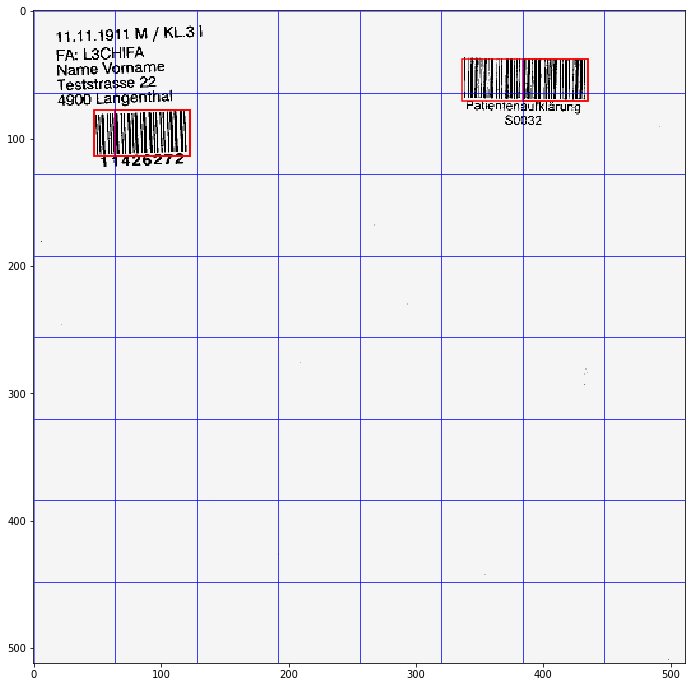

In [26]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(12, 12))

# Display the image
show_img_from_gen(ax, gen)
shape = gen[0]['input'].shape[1:3]

#r = patches.Rectangle((50,50),100,100,linewidth=2,edgecolor='r',facecolor='none')
#ax.add_patch(r)

from rect import Rect
def clip_rect(rect, h, w):
    return Rect(max(0, rect.left), max(0, rect.top), min(w, rect.right), min(h, rect.bottom))

for rect in rects[:]:
    # Create a Rectangle patch
    rr = clip_rect(rect, shape[0], shape[1])
    print rr
    #rr.dump()
    #rr.stretch(300, 300)
    #rr.dump()
    r = patches.Rectangle((rr.left,rr.top),rr.width(),rr.height(),linewidth=1.5,edgecolor='r' ,facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(r)
    
cnt = 8
edge = shape[0] / cnt
    
for i in range(cnt):
    for j in range(cnt):
    # Create a Rectangle patch
        rr = Rect(edge * i, edge * j, edge * (i + 1), edge * (j + 1))
        r = patches.Rectangle((rr.left,rr.top),rr.width(),rr.height(),linewidth=0.5,edgecolor='b',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(r)
    
for rect in []: #tr:
    # Create a Rectangle patch
    #rr = rect.copy()
    #rr.stretch(300, 300)
    r = patches.Rectangle((rr.left,rr.top),rr.width(),rr.height(),linewidth=1.5,edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(r)

plt.show()

i += 1